In [5]:
import os
os.sys.path.append("C:\\Users\mplitt\MightyMorphingPhotonRangers")
import numpy as np
import matplotlib.pyplot as plt
import utilities as u
import preprocessing as pp
import behavior as b
import SimilarityMatrixAnalysis as sm
import scipy as sp
import PlaceCellAnalysis as pc
import matplotlib.gridspec as gridspec
from sklearn.svm import SVC



%load_ext autoreload
%autoreload 2

%matplotlib inline

In [6]:
df = pp.load_session_db()


df = df[df['RewardCount']>30]
df = df[df['Imaging']==1]
df = df.sort_values(['MouseName','DateTime','SessionNumber'])
tracks = 'TwoTower_noTimeout|TwoTower_Timeout|Reversal_noTimeout|Reversal|TwoTower_foraging|FreqMorph_Decision|FreqMorph_Timeout'
df = df[df['Track'].str.contains(tracks,regex=True)]

G:\My Drive\VR_Data\TwoTower\behavior.sqlite
G:\My Drive\VR_Data\TwoTower\4222174.0\30_05_2019\RuningTraining_1.sqlite
file doesn't exist, errors to come!!!


In [57]:
morph_rare = ['4139265.3','4139265.4','4139265.5'] #,'4222175.0']
morph_familiar = ['4222153.2','4222154.1','4222153.1','4222157.3'] #,'4222174.1']

In [8]:
mouse = '4222157.4'
df_mouse = df[df['MouseName'].str.match(mouse)]
df_mouse

,MouseName,DateFolder,SessionNumber,Track,RewardCount,Imaging,ImagingRegion,DateTime,data file,scanfile,scanmat,s2pfolder
1999,4222157.4,04_06_2019,0,FreqMorph_Decision,100,1,CA1,2019-06-04,G:\My Drive\VR_Data\TwoTower\4222157.4\04_06_2...,None,G:\My Drive\2P_Data\TwoTower\4222157.4\04_06_2...,G:\My Drive\2P_Data\TwoTower\4222157.4\04_06_2...
2030,4222157.4,06_06_2019,1,FreqMorph_Decision,99,1,CA1,2019-06-06,G:\My Drive\VR_Data\TwoTower\4222157.4\06_06_2...,None,G:\My Drive\2P_Data\TwoTower\4222157.4\06_06_2...,G:\My Drive\2P_Data\TwoTower\4222157.4\06_06_2...
2054,4222157.4,08_06_2019,2,FreqMorph_Timeout,52,1,CA1,2019-06-08,G:\My Drive\VR_Data\TwoTower\4222157.4\08_06_2...,None,G:\My Drive\2P_Data\TwoTower\4222157.4\08_06_2...,G:\My Drive\2P_Data\TwoTower\4222157.4\08_06_2...
2079,4222157.4,11_06_2019,1,FreqMorph_Timeout,71,1,CA1,2019-06-11,G:\My Drive\VR_Data\TwoTower\4222157.4\11_06_2...,None,G:\My Drive\2P_Data\TwoTower\4222157.4\11_06_2...,G:\My Drive\2P_Data\TwoTower\4222157.4\11_06_2...
2101,4222157.4,13_06_2019,1,FreqMorph_Timeout,76,1,CA1,2019-06-13,G:\My Drive\VR_Data\TwoTower\4222157.4\13_06_2...,None,G:\My Drive\2P_Data\TwoTower\4222157.4\13_06_2...,G:\My Drive\2P_Data\TwoTower\4222157.4\13_06_2...
2114,4222157.4,14_06_2019,2,FreqMorph_Timeout,66,1,CA1,2019-06-14,G:\My Drive\VR_Data\TwoTower\4222157.4\14_06_2...,None,G:\My Drive\2P_Data\TwoTower\4222157.4\14_06_2...,G:\My Drive\2P_Data\TwoTower\4222157.4\14_06_2...
2128,4222157.4,15_06_2019,1,FreqMorph_Timeout,70,1,CA1,2019-06-15,G:\My Drive\VR_Data\TwoTower\4222157.4\15_06_2...,None,G:\My Drive\2P_Data\TwoTower\4222157.4\15_06_2...,G:\My Drive\2P_Data\TwoTower\4222157.4\15_06_2...
2137,4222157.4,17_06_2019,1,FreqMorph_Timeout,78,1,CA1,2019-06-17,G:\My Drive\VR_Data\TwoTower\4222157.4\17_06_2...,None,G:\My Drive\2P_Data\TwoTower\4222157.4\17_06_2...,G:\My Drive\2P_Data\TwoTower\4222157.4\17_06_2...
2155,4222157.4,18_06_2019,1,FreqMorph_Timeout,87,1,CA1,2019-06-18,G:\My Drive\VR_Data\TwoTower\4222157.4\18_06_2...,None,G:\My Drive\2P_Data\TwoTower\4222157.4\18_06_2...,G:\My Drive\2P_Data\TwoTower\4222157.4\18_06_2...


In [9]:
sess = df_mouse.iloc[-1]
print(sess)

MouseName                                                4222157.4
DateFolder                                              18_06_2019
SessionNumber                                                    1
Track                                            FreqMorph_Timeout
RewardCount                                                     87
Imaging                                                          1
ImagingRegion                                                  CA1
DateTime                                       2019-06-18 00:00:00
data file        G:\My Drive\VR_Data\TwoTower\4222157.4\18_06_2...
scanfile                                                      None
scanmat          G:\My Drive\2P_Data\TwoTower\4222157.4\18_06_2...
s2pfolder        G:\My Drive\2P_Data\TwoTower\4222157.4\18_06_2...
Name: 2155, dtype: object


In [58]:
def sess_lar(sess,max_pos=450,cellmask = None):
    VRDat, C, S, A = pp.load_scan_sess(sess,fneu_coeff=0.7)
    trial_info, tstart_inds, teleport_inds = u.by_trial_info(VRDat)


    effMorph = trial_info['morphs'] +  trial_info['wallJitter'] + trial_info['bckgndJitter']
    effMorph = (effMorph+.25)/1.5

    msort = np.argsort(effMorph)

    S_trial_mat, occ_trial_mat, edges,centers = u.make_pos_bin_trial_matrices(S,VRDat['pos']._values,VRDat['tstart']._values,VRDat['teleport']._values,bin_size=10,speed=VRDat['speed']._values)
    S_trial_mat[np.isnan(S_trial_mat)]=0
    posmask = centers<=max_pos
    S_tm = S_trial_mat[:,posmask,:].reshape([S_trial_mat.shape[0],-1])
    S_tm_norm = S_tm/np.linalg.norm(S_tm,ord=2,axis=1)[:,np.newaxis]


    lar = np.zeros(effMorph.shape)
    for trial in range(effMorph.shape[0]):
        mask0 = trial_info['morphs']==0
        mask1 = trial_info['morphs']==1
        if trial_info['morphs'][trial]==0:
            mask0[trial]=False
        elif trial_info['morphs'][trial]==1:
            mask1[trial]=False
            
        centroid0, centroid1 = np.nanmean(S_tm[mask0,:],axis=0), np.nanmean(S_tm[mask1,:],axis=0)
        centroid0/np.linalg.norm(centroid0,ord=2)
        centroid1/np.linalg.norm(centroid1,ord=2)
        
        lar[trial]= np.log(np.dot(S_tm_norm[trial,:],centroid0)/np.dot(S_tm_norm[trial,:],centroid1))
    return lar, effMorph
        

    

In [59]:
lar,em = sess_lar(sess,max_pos=450.)

num aberrant ttls 0.0
24753 (24753,) (24753, 21) 71281
frame diff 0


C:\Users\mplitt\MightyMorphingPhotonRangers\utilities.py:324: RuntimeWarning: Mean of empty slice
  zone1_speed[i] = np.nanmean(sub_frame.loc[zone1_mask,'speed'])


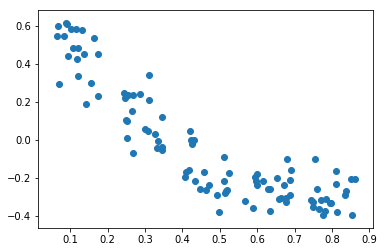

In [60]:
f,ax = plt.subplots()
ax.scatter(em,lar)

In [61]:
def LAR_list_maker(mlist,firstSess = None):
    LAR, EM = {},{}
    
    if firstSess is None:
        firstSess = len(mlist)*[5]
    elif isinstance(firstSess,int):
        firstSess = len(mlist)*[firstSess]
    else:
        pass
    
    
    for mouse,f_ind in zip(mlist,firstSess): 
        LAR[mouse],EM[mouse] = [],[]
        df_mouse = df[df['MouseName'].str.match(mouse)]
        for mat_ind,sess_ind in enumerate(np.arange(f_ind,df_mouse.shape[0])):
            print("session ind",sess_ind)
            
            sess = df_mouse.iloc[sess_ind]
#             print(sess)
            lar, em = sess_lar(sess)
            LAR[mouse].append(lar)
            EM[mouse].append(em)
    return LAR, EM

In [15]:
LAR_rd,EM_rd = LAR_list_maker(['4139224.2','4139224.3','4139224.5'])

session ind 5
num aberrant ttls 0.0
26741 (26741,) (26741, 20) 83632
frame diff 0
session ind 6
num aberrant ttls 0.0
23611 (23611,) (23611, 20) 75002
frame diff 0
session ind 7
num aberrant ttls 0.0
28600 (28600,) (28600, 20) 90254
frame diff 0
session ind 8
num aberrant ttls 0.0
24063 (24063,) (24063, 20) 76746
frame diff 0
session ind 9
num aberrant ttls 0.0
27943 (27943,) (27943, 20) 90302
frame diff 0
session ind 5
num aberrant ttls 0.0
31376 (31376,) (31376, 20) 99274
frame diff 0
session ind 6
num aberrant ttls 0.0
29572 (29572,) (29572, 20) 92598
frame diff 0
session ind 7
num aberrant ttls 0.0
37977 (37977,) (37977, 20) 121175
frame diff 0
session ind 8
num aberrant ttls 0.0
32188 (32188,) (32188, 20) 101194
frame diff 0
session ind 9
num aberrant ttls 0.0
28824 (28824,) (28824, 20) 89367
frame diff 0
session ind 10
num aberrant ttls 0.0
28114 (28114,) (28114, 20) 88941
frame diff 0
session ind 5
num aberrant ttls 0.0
18855 (18855,) (18855, 20) 59619
frame diff 0
session ind 6

In [37]:
LAR_fd,EM_fd = LAR_list_maker(['4222157.4'])

session ind 5
num aberrant ttls 0.0
27977 (27977,) (27977, 21) 78367
frame diff 0
session ind 6
num aberrant ttls 0.0
30469 (30469,) (30469, 21) 85961
frame diff 0
session ind 7
num aberrant ttls 0.0
27484 (27484,) (27484, 21) 78628
frame diff 0
session ind 8
num aberrant ttls 0.0
24753 (24753,) (24753, 21) 71281
frame diff 0


In [62]:
LAR_rare,EM_rare = LAR_list_maker(morph_rare)

session ind 5
num aberrant ttls 0.0
35085 (35085,) (35085, 21) 115307
frame diff 0
session ind 6
num aberrant ttls 0.0
33140 (33140,) (33140, 21) 109003
frame diff 0
session ind 7
num aberrant ttls 0.0
38209 (38209,) (38209, 21) 126969
frame diff 0
session ind 8
num aberrant ttls 0.0
33547 (33547,) (33547, 21) 110218
frame diff 0
session ind 9
num aberrant ttls 0.0
32038 (32038,) (32038, 21) 105022
frame diff 0
session ind 5
num aberrant ttls 0.0
30897 (30897,) (30897, 21) 102093
frame diff 0
session ind 6
num aberrant ttls 0.0
29023 (29023,) (29023, 21) 95160
frame diff 0
session ind 7
num aberrant ttls 0.0
31116 (31116,) (31116, 21) 102131
frame diff 0
session ind 8
num aberrant ttls 0.0
31932 (31932,) (31932, 21) 105228
frame diff 0
session ind 9
num aberrant ttls 0.0
30493 (30493,) (30493, 21) 100982
frame diff 0
session ind 10
num aberrant ttls 0.0
32084 (32084,) (32084, 21) 105601
frame diff 0
session ind 5
num aberrant ttls 0.0
34737 (34737,) (34737, 21) 113863
frame diff 0
sess

In [63]:
LAR_fam,EM_fam = LAR_list_maker(morph_familiar)

session ind 5
num aberrant ttls 0.0
33545 (33545,) (33545, 21) 121243
frame diff 0
session ind 6
num aberrant ttls 0.0
38697 (38697,) (38697, 21) 129389
frame diff 0
session ind 7
num aberrant ttls 0.0
37344 (37344,) (37344, 21) 121463
frame diff 0
session ind 5
num aberrant ttls 0.0
28890 (28890,) (28890, 21) 94524
frame diff 0
session ind 6
num aberrant ttls 0.0
31805 (31805,) (31805, 21) 105737
frame diff 0
session ind 7
num aberrant ttls 0.0
33473 (33473,) (33473, 21) 110483
frame diff 0
session ind 8
num aberrant ttls 0.0
34639 (34639,) (34639, 21) 115107
frame diff 0
session ind 5
num aberrant ttls 0.0
33778 (33778,) (33778, 21) 111444
frame diff 0
session ind 6
num aberrant ttls 0.0
35977 (35977,) (35977, 21) 118959
frame diff 0
session ind 5
num aberrant ttls 0.0
25336 (25336,) (25336, 21) 71554
frame diff 0
session ind 6
num aberrant ttls 0.0
30160 (30160,) (30160, 21) 83834
frame diff 0
session ind 7
num aberrant ttls 0.0
29242 (29242,) (29242, 21) 83453
frame diff 0


In [64]:

def plot_LAR(LAR,EM,cmap='copper'):
    cmap = plt.cm.get_cmap(cmap)
    f = plt.figure()
    gs = gridspec.GridSpec(1,5)
    ax_scat = f.add_subplot(gs[:,:4])
    ax_hist = f.add_subplot(gs[:,-1])
    N = len(LAR.keys())
    bins = np.linspace(-1,1)
    print(N)
    for i,mouse in enumerate(LAR.keys()):
        if len(LAR[mouse])>0:
            print(mouse)
            lar,em = np.concatenate(LAR[mouse]),np.concatenate(EM[mouse])
#             lar/=np.amax(lar)-np.amin(lar)
#             lar-=lar.mean()
#             lar/=np.amax(np.abs(lar))
            print(lar.shape)
            ax_scat.scatter(em,lar,color=cmap(np.float(i/N)),alpha=.4,s=8)
            hist,edges = np.histogram(lar,bins=bins)
            ax_hist.fill_betweenx(edges[1:],hist/hist.sum(),color=cmap(np.float(i/N)),alpha=.4)
            ax_hist.hist(lar,bins=50,orientation='horizontal',color=cmap(np.float(i/N)),alpha=.4,density=True)
    ax_hist.set_ylim([-1.2,1.2])
    ax_scat.set_ylim([-1.2,1.2])
    ax_hist.set_yticks([])
    return f,(ax_scat,ax_hist)

3
4139265.3
(600,)
4139265.4
(720,)
4139265.5
(600,)


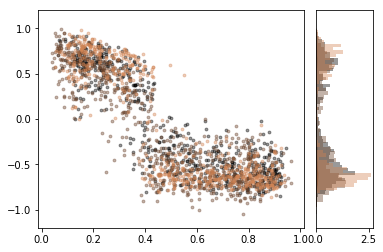

In [69]:
f,ax = plot_LAR(LAR_rare,EM_rare,cmap='copper')
f.savefig('morph_rare.svg',format='svg')

4
4222153.2
(305,)
4222154.1
(390,)
4222153.1
(186,)
4222157.3
(201,)


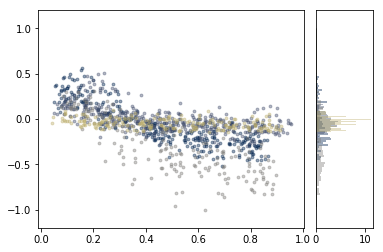

In [70]:
f,ax = plot_LAR(LAR_fam,EM_fam,cmap='cividis')
f.savefig('morph_fig.svg',format='svg')

3
4139224.2
(449,)
4139224.3
(540,)
4139224.5
(623,)


(<Figure size 432x288 with 2 Axes>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x13100490ba8>,
  <matplotlib.axes._subplots.AxesSubplot at 0x1310055f358>))

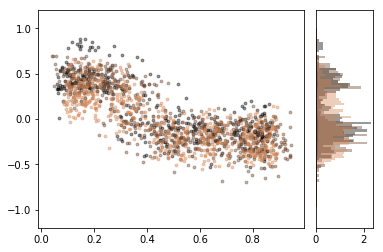

In [33]:
plot_LAR(LAR_rd,EM_rd)

1
4222157.4
(400,)


(<Figure size 432x288 with 2 Axes>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x13100771240>,
  <matplotlib.axes._subplots.AxesSubplot at 0x131024a9438>))

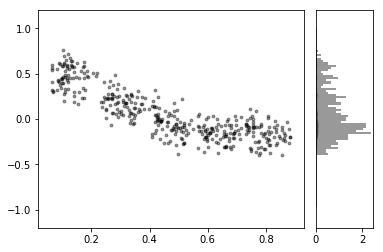

In [38]:
plot_LAR(LAR_fd,EM_fd)

In [67]:

def mega_lar(LAR,exclude=()):
    mega_lar =  []
    for k,v in LAR.items():
        if k not in exclude:
            mega_lar.extend(v)
    return np.concatenate(mega_lar)


mega_lar_fam = mega_lar(LAR_fam)
mega_lar_rare = mega_lar(LAR_rare)
mega_lar_rd = mega_lar(LAR_rd)

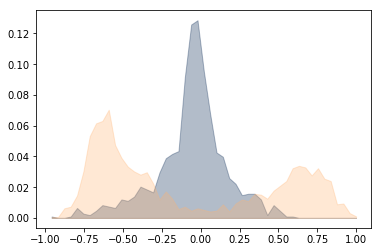

In [68]:
f,ax = plt.subplots()
bins = np.linspace(-1,1)
fam_hist,edges = np.histogram(mega_lar_fam,bins)
rare_hist,edges = np.histogram(mega_lar_rare,bins)
ax.fill_between(edges[1:],fam_hist/fam_hist.sum(),alpha=.3,color=plt.cm.cividis(0.))
ax.fill_between(edges[1:],rare_hist/rare_hist.sum(),alpha=.3,color=plt.cm.copper(.9))

In [53]:
D,p = sp.stats.ks_2samp(mega_lar_rare,mega_lar_fam)
print(D,p)

0.33020892707607646 1.1975522761638874e-79


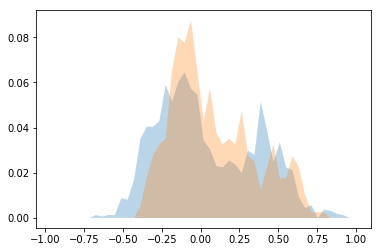

In [54]:
f,ax = plt.subplots()
bins = np.linspace(-1,1)
rd_hist,edges = np.histogram(mega_lar_rd,bins)
ax.fill_between(edges[1:],rd_hist/rd_hist.sum(),alpha=.3)
fd_hist,edges = np.histogram(np.concatenate(LAR_fd['4222157.4']),bins)
ax.fill_between(edges[1:],fd_hist/fd_hist.sum(),alpha=.3)

In [55]:
D,p = sp.stats.ks_2samp(mega_lar_rd,np.concatenate(LAR_fd['4222157.4']))

In [56]:
print(D,p)

0.14423076923076922 2.682174612207721e-06
